### Sentiment using attention

puntos clave:

> Word embedding es la representación semantica de una palabra
en vez de usar one-hot vector


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [2]:
# 1. Tiny dataset
data = [
    (["I", "love", "cats"], 1),
    (["I", "hate", "war"], 0),
    (["we", "enjoy", "music"], 1),
    (["they", "fear", "pain"], 0),
    (["she", "loves", "peace"], 1),
    (["he", "hates", "noise"], 0)
]

In [7]:
# 2. Vocabulary and mapping
vocab = {word: idx for idx, word in enumerate(sorted(set(w for sent, _ in data for w in sent)))}
vocab_size = len(vocab)
embedding_dim = 8

def encode(sentence):
    return torch.tensor([vocab[word] for word in sentence], dtype=torch.long)

# 3. Dataset
class TinySentimentDataset(Dataset):
    def __init__(self, data):
        self.samples = [(encode(sent), torch.tensor(label)) for sent, label in data]

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

dataset = TinySentimentDataset(data)
loader = DataLoader(dataset, batch_size=3, shuffle=True)

In [8]:
encode(["I", "love", "cats"])

tensor([0, 7, 1])

In [ ]:
# 4. Self-attention classifier
class SelfAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.q = nn.Linear(embedding_dim, embedding_dim)
        self.k = nn.Linear(embedding_dim, embedding_dim)
        self.v = nn.Linear(embedding_dim, embedding_dim)
        self.ff = nn.Sequential(nn.Linear(embedding_dim, 1))
        self.scale = embedding_dim ** 0.5

    def forward(self, x):
        x = self.embed(x)  # (B, L, D)
        Q, K, V = self.q(x), self.k(x), self.v(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attn_weights = F.softmax(scores, dim=-1)
        attended = torch.matmul(attn_weights, V)  # (B, L, D)
        print(attended.shape)
        # sacamos la media sobre la longitud de secuencia 
        # la dimensin L desaparece por lo tanto 
        summary = attended.mean(dim=1) #output shape is (B, D)        
        print(summary.shape)
        logits = self.ff(summary).squeeze(1) #output shape is (B)
        print(logits.shape)
        return logits, attn_weights

In [10]:
model = SelfAttentionClassifier(vocab_size, embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

In [11]:
# 5. Training loop
for epoch in range(50):
    for x, y in loader:
        logits, _ = model(x)
        loss = loss_fn(logits, y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item():.4f}")

torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
Epoch 0 Loss: 0.6575
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size([3, 3, 8])
torch.Size([3, 8])
torch.Size([3])
torch.Size

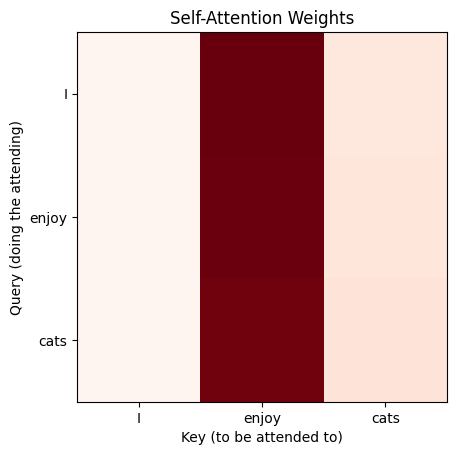

In [13]:
def show_attention(sentence):
    model.eval()
    tokens = encode(sentence).unsqueeze(0)  # (1, L)
    _, attn = model(tokens)
    weights = attn[0].detach().numpy()  # shape (L, L)

    plt.imshow(weights, cmap='Reds')
    plt.xticks(range(len(sentence)), sentence)
    plt.yticks(range(len(sentence)), sentence)
    plt.title("Self-Attention Weights")
    plt.xlabel("Key (to be attended to)")
    plt.ylabel("Query (doing the attending)")
    #plt.colorbar()
    plt.show()

show_attention(["I", "enjoy", "cats"])



### BERT

In [17]:
import torch 
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

In [19]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_attentions = True)